In [9]:
import cobra
from cobra import Model, Reaction, Metabolite

model = cobra.io.load_json_model('e_coli_core.json')
model

Name,e_coli_core
Memory address,24aaf599df0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


#### Excercise 1.

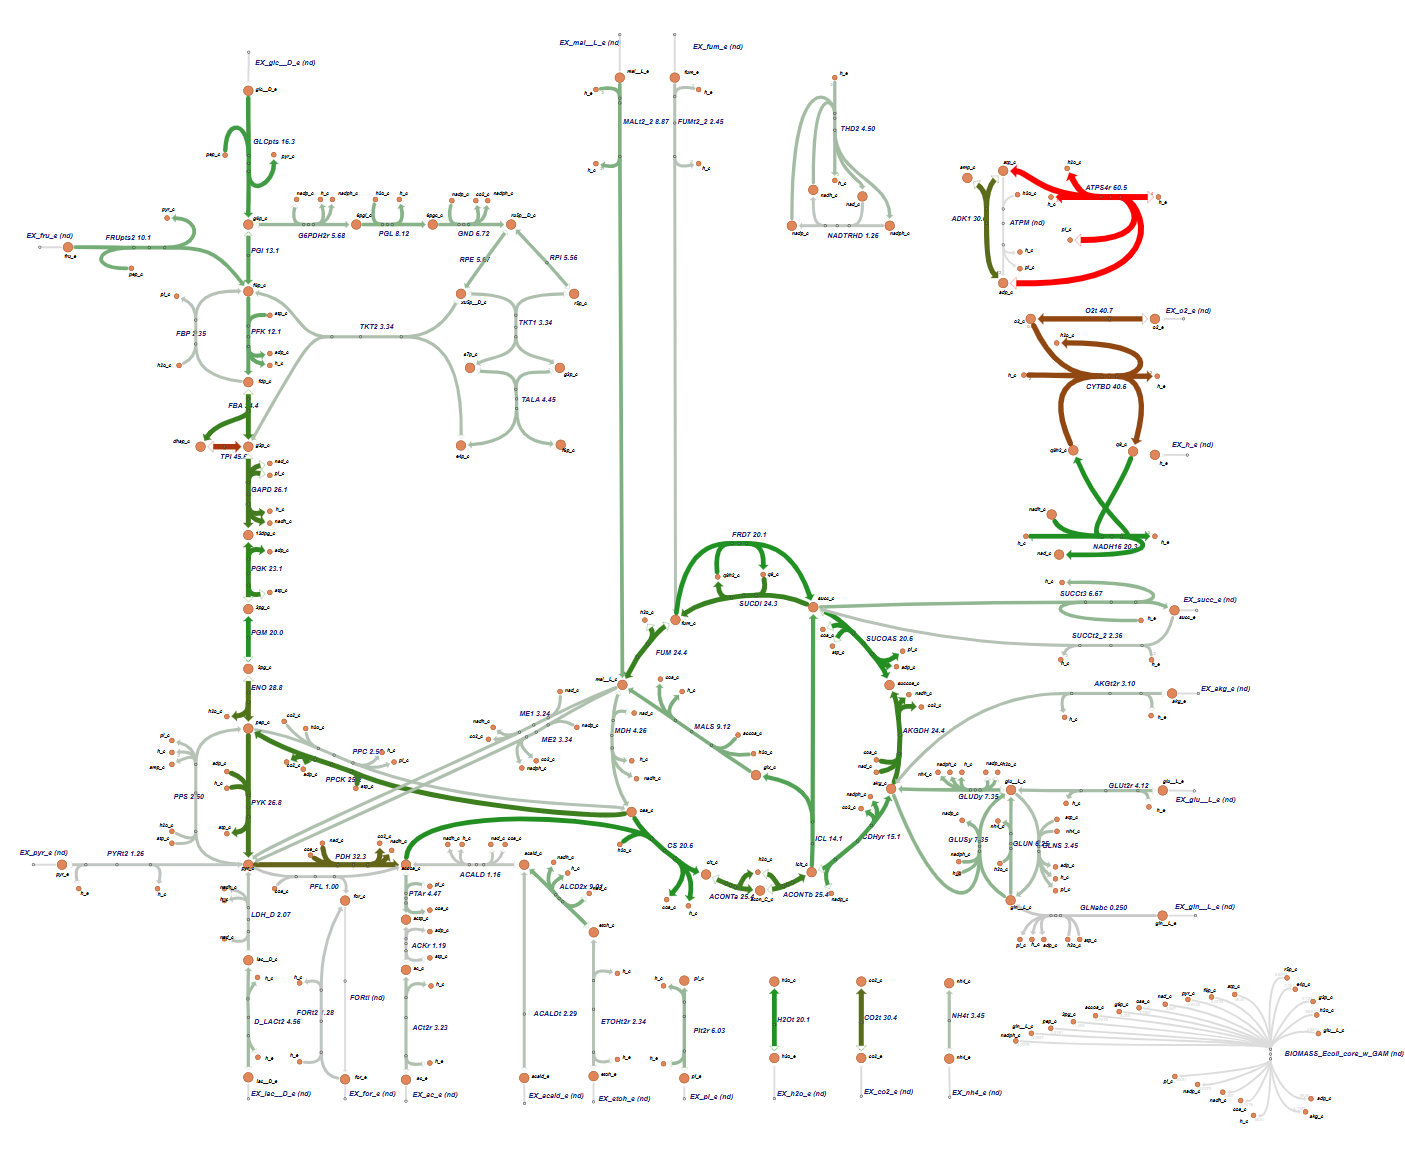

a) In the interactive session, we saw reaction fluxes in a linear pathway being equal to each other due
to mass balance constraints. Do you observe the same thing now for the maximal reaction activities?
Explain your observations. [5 pt]

    Whereas in the interactive session we were looking at fluxes (that show the actual flow of metabolites through a given reaction under steady-state conditions), in this case we are visualizing maximal reaction activities that represent the enzyme capacities inferred from gene expression (aka this is the upper bound of a given reaction's flux based on the availability of enzymes). These two are fundementally different concepts.

    Also, the availability of different enzymes might (most likely) be different, hence the maximal reaction activities will look different. Reactions catalyzed by highly expressed enzymes will have larger capacities, than reactions catalyzed by enzymes with lower availability.

    At steady-state the actual flux must satisfy both mass balance and capacity constraints, however in certain conditions some capacities will not neccessarily be fully used.

b) Some reactions have no maximal reaction activity data. Identify at least two different kinds of such
reactions, and explain why gene expression-derived data would not be applicable for these kinds of
reactions. [5 pt]


In [10]:
for r in model.reactions:
    if r.gene_reaction_rule == '':
        print(r.id, r.name)

ATPM ATP maintenance requirement
ACt2r Acetate reversible transport via proton symport
BIOMASS_Ecoli_core_w_GAM Biomass Objective Function with GAM
PYRt2 Pyruvate transport in via proton symport
SUCCt3 Succinate transport out via proton antiport
ETOHt2r Ethanol reversible transport via proton symport
EX_ac_e Acetate exchange
EX_acald_e Acetaldehyde exchange
EX_akg_e 2-Oxoglutarate exchange
EX_co2_e CO2 exchange
EX_etoh_e Ethanol exchange
EX_for_e Formate exchange
EX_fru_e D-Fructose exchange
EX_fum_e Fumarate exchange
EX_glc__D_e D-Glucose exchange
EX_gln__L_e L-Glutamine exchange
EX_glu__L_e L-Glutamate exchange
EX_h_e H+ exchange
EX_h2o_e H2O exchange
EX_lac__D_e D-lactate exchange
EX_mal__L_e L-Malate exchange
EX_nh4_e Ammonia exchange
EX_o2_e O2 exchange
EX_pi_e Phosphate exchange
EX_pyr_e Pyruvate exchange
EX_succ_e Succinate exchange


As we can see from above, there are exactly 26 such reactions that we can group in the following way:

1. exchange reactions: These reactions represent the import or export of metabolites between the cell and its environment. These are are not enzyme-catalyzed processes, hence would not make sense to associate gene-expression data with these processes. (eg. EX_ac_e, EX_fru_e)

2. transport reactions: These reactions represent the transportation of metabolites within the cell. Since these are via proton symport/antiport the reaction is not a standard gene-enzyme-reaction step, so a gene expression cannot be mapped. (eg. ACt2r, PYRt2, SUCCt3, ETOHt2r)

3.  pseudo-reaction (BIOMASS_Ecoli_core_w_GAM): This is the objective function of the system and not a 'real reaction'. This reaction doesn't correspond to a single enzyme encoded by a gene, so there is no expression level to assign.

4. maintenance reaction (ATPM): This is a maintenance requirement to keep the cell alive and like in the previous category, this doesn't correspond to a single enzyme eeither, so there is no expression level to assign.

#### Excercise 2.

We will now establish an enzyme activity-constrained metabolic model in COBRApy. Please
implement the maximal reaction activity data in the
E. coli core model from the practical per the below
instructions.
- For reversible reactions, set the lower and upper flux bound to -value and +value, respectively (“value”
as the maximal reaction activity).
- For irreversible reactions, only set the maximal flux bound to value and leave the minimal flux bound
at zero.
- For reactions without data, leave their default constraints.
- For the glucose exchange reaction (see practical), please remove the maximal absolute flux bound
and use the high absolute default bound instead. (We assume the subsequent transporter maximal
activity accounts for maximal glucose uptake.)
- For the ATPM energy maintenance reaction (see practical), leave the lower flux as-is, since it describes
cellular energy requirements separate from any maximal reaction activities.
Please print a table listing each reaction’s lower and upper flux bound after implementing the above (no
formatting requirements, simple printout sufficient). [30 pt]

In [20]:
from pathlib import Path
import pandas as pd
from cobra.io import load_json_model

model_path = Path("e_coli_core.json")                
expr_path  = Path("e_coli_core_expression.csv")

# load model
model = load_json_model(str(model_path))

# saving the original bounds of the sys so we can preserve ATPM lower bound for later
original_bounds = {r.id: (r.lower_bound, r.upper_bound) for r in model.reactions}

# read maximal activities
raw = pd.read_csv(expr_path, header=None)
try:
    float(raw.iloc[0,1])
    df = raw.iloc[:, :2].copy()
    df.columns = ["reaction_id", "max_activity"]
except Exception:
    df = pd.read_csv(expr_path) 
    cols = {c.lower(): c for c in df.columns}
    rid_col = cols.get("reaction_id", list(df.columns)[0])
    val_col = cols.get("max_activity", list(df.columns)[1])
    df = df[[rid_col, val_col]].copy()
    df.columns = ["reaction_id", "max_activity"]

df["reaction_id"] = df["reaction_id"].astype(str).str.strip()
df["max_activity"] = pd.to_numeric(df["max_activity"], errors="coerce").fillna(0.0)
activity = dict(zip(df["reaction_id"], df["max_activity"]))

#  set reaction bounds
for r in model.reactions:
    if r.id in activity:
        vmax = max(0.0, float(activity[r.id]))
        if r.reversibility:
            r.lower_bound = -vmax
            r.upper_bound =  vmax
        else:
            r.upper_bound = vmax
            r.lower_bound = 0.0

#  uncap glucose exchange and set high absolute default bounds (±1000)
for glc in ["EX_glc__D_e", "EX_glc__D_lp_e", "EX_glc_e"]:
    if glc in model.reactions:
        r = model.reactions.get_by_id(glc)
        r.lower_bound = -1000.0
        r.upper_bound = 1000.0

# reset ATPM lower bound to its original value
model.reactions.get_by_id("ATPM").lower_bound = original_bounds["ATPM"][0]

# print new bounds
bounds = []
for r in model.reactions:
    bounds.append({
        "reaction": r.id,
        "reversible": r.reversibility,
        "lower_bound": float(r.lower_bound),
        "upper_bound": float(r.upper_bound),
        "flux": float(activity.get(r.id, float("nan")))
    })
bounds_df = pd.DataFrame(bounds).sort_values("reaction").reset_index(drop=True)
print(bounds_df.head(95).to_string(index=False))

                reaction  reversible  lower_bound  upper_bound  flux
                   ACALD        True        -1.16         1.16  1.16
                  ACALDt        True        -2.29         2.29  2.29
                    ACKr        True        -1.19         1.19  1.19
                  ACONTa        True       -25.35        25.35 25.35
                  ACONTb        True       -25.35        25.35 25.35
                   ACt2r        True        -3.23         3.23  3.23
                    ADK1        True       -30.57        30.57 30.57
                   AKGDH       False         0.00        24.35 24.35
                  AKGt2r        True        -3.10         3.10  3.10
                  ALCD2x        True        -9.01         9.01  9.01
                    ATPM       False         8.39      1000.00   NaN
                  ATPS4r        True       -60.50        60.50 60.50
BIOMASS_Ecoli_core_w_GAM       False         0.00      1000.00   NaN
                    CO2t        Tr

#### Excercise 3.

In [ ]:
### Angelo

#### Excercise 4.